In [36]:
import wandb
import pandas as pd
import os
from tqdm import tqdm

from table_plotter import print_result_table

In [37]:
api = wandb.Api(timeout=600)


In [38]:
# get all runs for a project
runs = api.runs("inchangbaek4907/pcgrl-llm")
len(runs)

195

In [41]:
import re

# Specify cache directory
cache_dir = "./wandb_cache"
os.makedirs(cache_dir, exist_ok=True)

dfs = []
skipped_runs = []  # List to store IDs of skipped runs

for run in tqdm(runs):
    # Skip the run if it's not finished
    if run.state != "finished":
        print(f"Skipping run {run.id} (state: {run.state})")
        skipped_runs.append(run.id)
        continue


    # Get the key of the run
    from pprint import pprint

    
    run_ids = list(run.historyKeys['keys'].keys())
    # filter starts with 'Iteration_'
    pattern = r'^Iteration_\d+/train'
    # 필터링
    iteration_ids = list(filter(lambda x: re.match(pattern, x), run_ids))
    print(iteration_ids)
    
    
    ['ep_return', 'code', 'config', 'fps', 'video', 'image', 'ep_length']
    
    # Define cache filename based on run ID
    cache_file = os.path.join(cache_dir, f"{run.id}.csv")
    
    # Check if cached file exists
    if os.path.exists(cache_file):
        # Load cached DataFrame
        df = pd.read_csv(cache_file)
    else:
        try:
            # Iteration_7/train/similarity 이런식으로 해야함
            # Retrieve history data for Evaluation/similarity and diversity
            sim = run.history(keys=["Train/similarity"])
            div = run.history(keys=["Train/diversity"])
            llm_sim = run.history(keys=["Train/llm/similarity"])
            llm_div = run.history(keys=["Train/llm/diversity"])

            # Merge DataFrames
            print(sim)
            # print(sim)

            # df = df.drop(columns=["_step_x", "_step_y"], errors="ignore")

            print(sim)

            # Add run config to DataFrame with prefix 'config.'
            for key, value in run.config.items():
                if isinstance(value, list):
                    value = ",".join(map(str, value))  # Convert list to comma-separated string
                df[key] = value

            # Filter columns
            key_filter = ['target_character', 'pe', 'branch_factor', 'exp_name', 'evaluator', 'total_iterations',
                          'reward_feature', 'fewshot', 'problem', 'seed', 'Evaluation/llm_iteration',
                          'Evaluation/similarity', 'Evaluation/diversity']
            auxiliary_key_filter = ['Evaluation/llm/similarity', 'Evaluation/llm/diversity']

            try:
                df = df[key_filter + auxiliary_key_filter]
            except KeyError:
                df = df[key_filter]

            # Save DataFrame to cache as CSV
            df.to_csv(cache_file, index=False)
        except KeyError as e:
            print(f"Skipping run {run.id} due to KeyError: {e}")
            break
            continue
        
        
    
    
    
    # Append DataFrame to list
    dfs.append(df)
    break

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)
df.head()  # Display the first few rows for inspection

# Print summary of skipped runs
print("\nSummary of Skipped Runs:")
print(f"Total skipped runs: {len(skipped_runs)}")
print("Skipped run IDs:", skipped_runs)

  0%|          | 0/195 [00:00<?, ?it/s]

['Iteration_1/train/ep_return', 'Iteration_1/train/code', 'Iteration_1/train/ep_return_max', 'Iteration_1/train/similarity', 'Iteration_1/train/config', 'Iteration_1/train/ep_return_min', 'Iteration_1/train/fps', 'Iteration_1/train/video', 'Iteration_1/train/image', 'Iteration_1/train/ep_length']


  0%|          | 0/195 [00:02<?, ?it/s]

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


NameError: name 'df' is not defined

In [20]:

time_str = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")

In [21]:
df.to_csv(f"wandb_output_{time_str}_graph.csv", index=False)

In [22]:

df['seed'] = df['seed'] % 3
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,M,got,2,longiter,vit,9,array,False,binary,0,5,0.049230,0.167293,NaN,NaN
1123,M,got,2,longiter,vit,9,array,False,binary,0,6,0.051012,0.167400,NaN,NaN
1124,M,got,2,longiter,vit,9,array,False,binary,0,7,0.202214,0.204327,NaN,NaN
1125,M,got,2,longiter,vit,9,array,False,binary,0,8,0.608841,0.016238,NaN,NaN


In [23]:
# remove pe == cotsc
df = df[df['pe'] != 'cotsc']

# if the exname is not def make the pe to 'pe+exp_name'
df['pe'] = df.apply(lambda x: x['pe'] + '-' +  x['exp_name'] if x['exp_name'] != 'def' else x['pe'], axis=1)

In [24]:
df.groupby(['pe', 'evaluator', 'fewshot', 'seed']).count()

target_character  branch_factor  \
pe           evaluator fewshot seed                                    
cot          vit       False   0                   24             24   
                               1                   36             36   
                               2                   30             30   
                       True    0                   30             30   
                               1                   30             30   
                               2                   30             30   
cot-encfb    vit       False   0                   30             30   
                               1                   30             30   
                               2                   29             29   
got          llm       False   0                   30             30   
                               1                   30             30   
                               2                   30             30   
             vit       False   0                   30             30   
                               1                   30             30   
                               2                   25             25   
                       True    0                   30             30   
                               1                   30             30   
                               2                   30             30   
got-encfb    vit       False   0                   28             28   
                               1                   25             25   
                               2                   30             30   
got-longiter vit       False   0                   45             45   
                               1                   45             45   
                               2                   45             45   
io           vit       False   0                    5              5   
                               1                    5              5   
                               2                    5              5   
tot          llm       False   0                   30             30   
                               1                   30             30   
                               2                   30             30   
             vit       False   0                   30             30   
                               1                   30             30   
                               2                   30             30   
                       True    0                   30             30   
                               1                   30             30   
                               2                   30             30   
tot-encfb    vit       False   0                   30             30   
                               1                   30             30   
                               2                   30             30   

                                     exp_name  total_iterations  \
pe           evaluator fewshot seed                               
cot          vit       False   0           24                24   
                               1           36                36   
                               2           30                30   
                       True    0           30                30   
                               1           30                30   
                               2           30                30   
cot-encfb    vit       False   0           30                30   
                               1           30                30   
                               2           29                29   
got          llm       False   0           30                30   
                               1           30                30   
                               2           30                30   
             vit       False   0           30                30   
                               1           30                30   
            

In [25]:
# Min-max Normalize Evaluation/similarity and Evaluation/diversity for each 'target_character' and add a new column 'Evaluation/similarity/norm' and 'Evaluation/diversity/norm'
df['Evaluation/similarity/norm'] = df.groupby('target_character')['Evaluation/similarity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Evaluation/diversity/norm'] = df.groupby('target_character')['Evaluation/diversity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity,Evaluation/similarity/norm,Evaluation/diversity/norm
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN,0.010878,1.000000
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN,0.045574,0.315946
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN,0.950696,0.000000
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN,0.034002,0.247650
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN,0.947774,0.000649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,M,got-longiter,2,longiter,vit,9,array,False,binary,0,5,0.049230,0.167293,NaN,NaN,0.050856,0.357254
1123,M,got-longiter,2,longiter,vit,9,array,False,binary,0,6,0.051012,0.167400,NaN,NaN,0.053114,0.357481
1124,M,got-longiter,2,longiter,vit,9,array,False,binary,0,7,0.202214,0.204327,NaN,NaN,0.244729,0.436339
1125,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,0.608841,0.016238,NaN,NaN,0.760041,0.034675


In [26]:
exp4_df = df[df['pe'].isin(['io','got','cot','tot'])]
exp4_df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,Evaluation/llm_iteration,Evaluation/similarity,Evaluation/diversity,Evaluation/llm/similarity,Evaluation/llm/diversity,Evaluation/similarity/norm,Evaluation/diversity/norm
0,N,io,2,def,vit,1,array,False,binary,1,1,0.018449,0.595029,NaN,NaN,0.010878,1.000000
1,M,io,2,def,vit,1,array,False,binary,1,1,0.045062,0.147950,NaN,NaN,0.045574,0.315946
2,F,io,2,def,vit,1,array,False,binary,1,1,0.799518,0.000000,NaN,NaN,0.950696,0.000000
3,D,io,2,def,vit,1,array,False,binary,1,1,0.032404,0.137656,NaN,NaN,0.034002,0.247650
4,C,io,2,def,vit,1,array,False,binary,1,1,0.765589,0.000347,NaN,NaN,0.947774,0.000649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,C,cot,2,def,vit,6,array,False,binary,1,2,0.190405,0.097447,NaN,NaN,0.226978,0.182235
988,C,cot,2,def,vit,6,array,False,binary,1,3,0.155776,0.000000,NaN,NaN,0.183582,0.000000
989,C,cot,2,def,vit,6,array,False,binary,1,4,0.195345,0.195051,NaN,NaN,0.233168,0.364763
990,C,cot,2,def,vit,6,array,False,binary,1,5,0.199735,0.068222,NaN,NaN,0.238671,0.127580


In [27]:
result_similarity = (
    exp4_df.groupby(['pe', 'Evaluation/llm_iteration'])['Evaluation/similarity/norm']
    .agg(['mean', 'std'])
    .reset_index()
)
print(result_similarity)

     pe  Evaluation/llm_iteration      mean       std
0   cot                         1  0.252587  0.340240
1   cot                         2  0.198929  0.314297
2   cot                         3  0.206384  0.323097
3   cot                         4  0.210164  0.334492
4   cot                         5  0.224511  0.329110
5   cot                         6  0.228633  0.358249
6   got                         1  0.270872  0.329117
7   got                         2  0.206757  0.334107
8   got                         3  0.171309  0.278013
9   got                         4  0.176141  0.283373
10  got                         5  0.222640  0.333709
11  got                         6  0.200681  0.301431
12   io                         1  0.201169  0.330079
13  tot                         1  0.285430  0.338536
14  tot                         2  0.141772  0.263439
15  tot                         3  0.178282  0.315603
16  tot                         4  0.124570  0.219752
17  tot                     

In [28]:
result_diversity = (
    exp4_df.groupby(['pe', 'Evaluation/llm_iteration'])['Evaluation/diversity/norm']
    .agg(['mean', 'std'])
    .reset_index()
)
print(result_diversity)

     pe  Evaluation/llm_iteration      mean       std
0   cot                         1  0.143771  0.225908
1   cot                         2  0.263695  0.236798
2   cot                         3  0.240868  0.246929
3   cot                         4  0.217382  0.232959
4   cot                         5  0.293386  0.250869
5   cot                         6  0.247962  0.267862
6   got                         1  0.177680  0.251968
7   got                         2  0.264409  0.236257
8   got                         3  0.245866  0.259179
9   got                         4  0.263827  0.259450
10  got                         5  0.210922  0.211891
11  got                         6  0.227834  0.216886
12   io                         1  0.304404  0.302951
13  tot                         1  0.225451  0.264817
14  tot                         2  0.206418  0.220935
15  tot                         3  0.228501  0.222504
16  tot                         4  0.288338  0.231612
17  tot                     

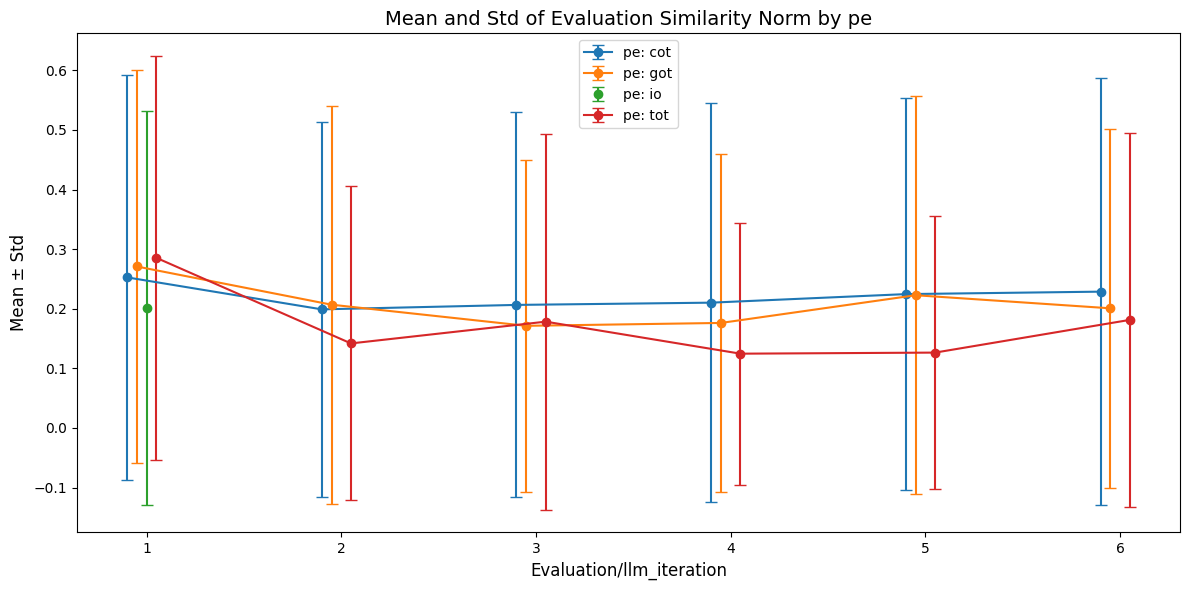

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x_values = sorted(result_similarity['Evaluation/llm_iteration'].unique())

pe_values = result_similarity['pe'].unique()

x_positions = np.arange(len(x_values))
offset = 0.05  # pe 간 간격 조정

plt.figure(figsize=(12, 6))

for i, pe in enumerate(pe_values):
    pe_data = result_similarity[result_similarity['pe'] == pe]
    x_values_pe = pe_data['Evaluation/llm_iteration'].to_numpy() - 1  # pe에 해당하는 x 값
    means = pe_data['mean'].to_numpy()  # pe에 해당하는 mean 값
    stds = pe_data['std'].to_numpy()   # pe에 해당하는 std 값

    adjusted_x = x_values_pe + (i - len(pe_values) / 2) * offset


    if pe == 'io':
        # 주석 체크(errorbar on/off)
        # plt.scatter(x_values_pe, means, label=f'pe: {pe}', s=50)
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='o', label=f'pe: {pe}', capsize=4)
    else:
        # plt.plot(x_values_pe, means, marker='o', label=f'pe: {pe}')
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='-o', label=f'pe: {pe}', capsize=4)

plt.xlabel('Evaluation/llm_iteration', fontsize=12)
plt.ylabel('Mean ± Std', fontsize=12)
plt.title('Mean and Std of Evaluation Similarity Norm by pe', fontsize=14)
plt.xticks(x_positions, x_values)  # x축 값 중앙 정렬
plt.legend()
plt.tight_layout()

# 그래프 표시
plt.show()


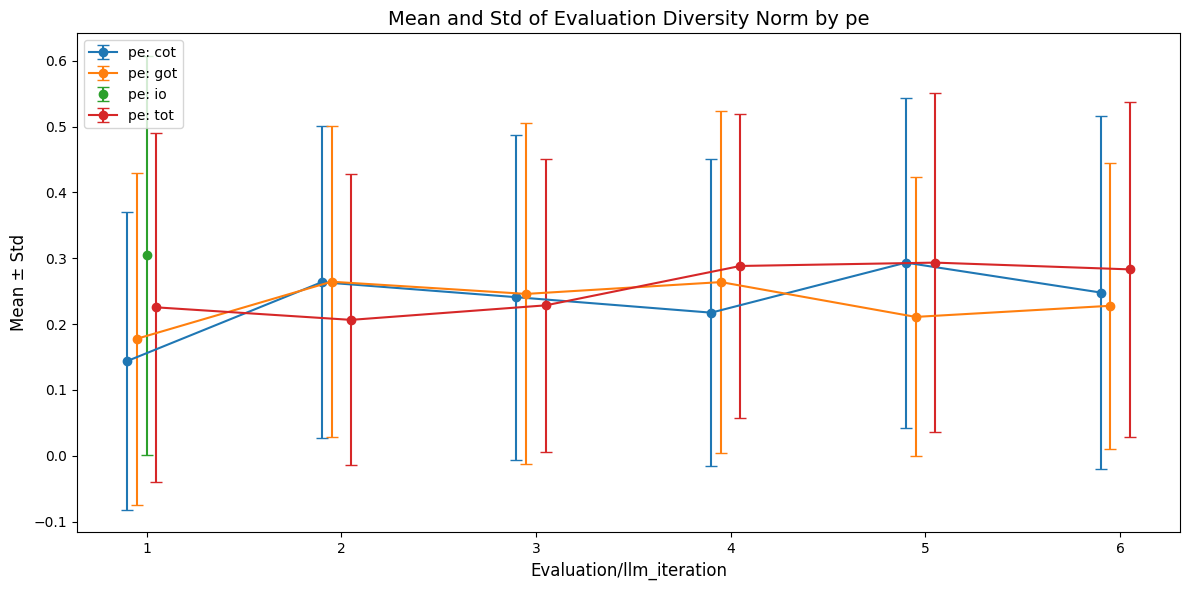

In [30]:
import matplotlib.pyplot as plt
import numpy as np

x_values = sorted(result_diversity['Evaluation/llm_iteration'].unique())

pe_values = result_diversity['pe'].unique()

x_positions = np.arange(len(x_values))
offset = 0.05  # pe 간 간격 조정

plt.figure(figsize=(12, 6))


for i, pe in enumerate(pe_values):
    pe_data = result_diversity[result_diversity['pe'] == pe]
    x_values_pe = pe_data['Evaluation/llm_iteration'].to_numpy() -1  # pe에 해당하는 x 값
    means = pe_data['mean'].to_numpy()  # pe에 해당하는 mean 값
    stds = pe_data['std'].to_numpy()   # pe에 해당하는 std 값


    adjusted_x = x_values_pe + (i - len(pe_values) / 2) * offset

    if pe == 'io':
        # 주석 체크(errorbar on/off)
        # plt.scatter(x_values_pe, means, label=f'pe: {pe}', s=50)
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='o', label=f'pe: {pe}', capsize=4)
    else:
        # plt.plot(x_values_pe, means, marker='o', label=f'pe: {pe}')
        plt.errorbar(adjusted_x, means, yerr=stds, fmt='-o', label=f'pe: {pe}', capsize=4)

# 축 레이블 및 제목 설정
plt.xlabel('Evaluation/llm_iteration', fontsize=12)
plt.ylabel('Mean ± Std', fontsize=12)
plt.title('Mean and Std of Evaluation Diversity Norm by pe', fontsize=14)
plt.xticks(x_positions, x_values)  # x축 값 중앙 정렬
plt.legend()
plt.tight_layout()

# 그래프 표시
plt.show()
